# Benchmark of intronic variation impacting RNA Splicing

This notebook refers to a comprehensive analysis of the prediction tools performance on variants that affect RNA Splicing. We spent a great ammount of time gathering and curating a dataset of pathogenic intronic variation located outside of canonical splice sites. Additionally, we carefully collected non-redundant variants from multiple recent studies that were shown to affect splicing outcome. Particularly, we were able to generate valuable subsets of variants that affect splicing differently (e.g. creating cryptic splice sites, affecting splicing regulatory elements, strenghning of existing cryptic sites, branchpoint disruption, etc). 

 After dataset collecion and running of the tools (most of them annotated using existing pre-computed scores), most of the analysis were performed with [VETA](https://github.com/PedroBarbosa/VETA), a simple standalone tool designed to benchmark prediction tools from VCF files. VETA's single requirement is that it just accepts VCFs annotated with [Ensembl VEP](https://www.ensembl.org/info/docs/tools/vep/script/index.html), because the `CSQ` INFO field is used to extract additional information about the variants being evaluated. 

In [2]:
import os
from wand.image import Image as WImage

os.makedirs("out", exist_ok=True)

## **Clinvar v202204**

### *Data processing*

After annotating Clinvar with Ensembl VEP (Consequences in `CSQ` field automatically picked and filtered with `--per_gene --pick_order ccds,canonical,biotype,rank --no_intergenic --gencode_basic'`), we selected SNVs with any `intronic` consequence ocurring in protein coding genes and with Pathogenic/Likely pathogenic or Benign/Likely benign classifications. From there, we filtered those variants that are also exonic in any other transcript structure, so that at the end we keep only variants that are unequivocally intronic.

In [2]:
# Variants with any intronic consequence
#! bcftools view -v snps clinvar_annotated.vcf.gz | filter_vep --only_matched --filter '(BIOTYPE is protein_coding and HGVSc and INTRON) and (CLNSIG is Pathogenic or CLNSIG is Likely_pathogenic or CLNSIG is Pathogenic/Likely_pathogenic or CLNSIG is Benign or CLNSIG is Likely_benign or CLNSIG is Benign/Likely_benign)' | bgzip > clinvar_any_intronic_conseq_snvs.vcf.gz

# From any intronic, get those that have any exonic consequence and remove those
#! bcftools isec isec_to_get_exonic -p isec_to_get_exonic clinvar_annotated.vcf.gz clinvar_any_intronic_conseq_snvs.vcf.gz 
#! cat isec_to_get_exonic/0002.vcf | filter_vep --only_matched --filter 'EXON' | bgzip > any_exonic.vcf.gz
#! bcftools isec -p to_get_non_exonic clinvar_any_intronic_conseq_snvs.vcf.gz any_exonic.vcf.gz && mv to_get_non_exonic/0000.vcf to_get_non_exonic/non_exonic.vcf && bgzip to_get_non_exonic/non_exonic.vcf

# Non_exonic still contains many 'downstream_gene_variant', 'upstream_gene_variant', 'TF_binding_site_variant' and 'regulatory_region_variant'.
# filter_vep --only_matched --filter 'Consequence is TF_binding_site_variant or Consequence is regulatory_region_variant or Consequence is upstream_gene_variant or Consequence is downstream_gene_variant' --input to_get_non_exonic/non_exonic.vcf.gz | bgzip > no_gene_body.vcf.gz
# filter_vep --only_matched --filter 'Consequence != TF_binding_site_variant and Consequence != regulatory_region_variant and Consequence != upstream_gene_variant and Consequence != downstream_gene_variant' --input to_get_non_exonic/non_exonic.vcf.gz | bgzip > in_gene_body.vcf.gz

# From the no_gene_body set, select only those variants that are annotated in Clinvar (MC) with intronic ontology terms (filter_vep and bcftools filter had issues filtering this field)
#! zcat no_gene_body.vcf.gz | grep -v "^#" | grep -w -e 'MC=SO:0001574|splice_acceptor_variant' -e 'MC=SO:0001627|intron_variant' -e 'MC=SO:0001575|splice_donor_variant' | grep -v -e "SO:0001583|missense_variant" -e "SO:0001819|synonymous_variant" -e "SO:0001587|nonsense" -e "SO:0001582|initiatior_codon_variant" -e "SO:0001578|stop_lost" > no_gene_body_intronic_in_MC_field.vcf
# bcftools view -h no_gene_body.vcf.gz > h && cat h no_gene_body_intronic_in_MC_field.vcf | bgzip > no_gene_body_intronic_in_MC_field.vcf.gz && rm no_gene_body_intronic_in_MC_field.vcf

# From the in_gene_body set, we will remove those that have no_gene_body consequences
# bcftools isec -p in_gene_body_only in_gene_body.vcf.gz no_gene_body_intronic_in_MC_field.vcf.gz && mv in_gene_body_only/0000.vcf in_gene_body_only/in_gene_body_only.vcf

# From the no_gene_body intronic set that , we will select the pathogenic variant or those with any splice-related consequence . 
# filter_vep --input in_gene_body_only/0002.vcf --filter 'CLNSIG match athogenic or Consequence matches splice' | bgzip > no_gene_body_intronic_splicing.vcf.gz

# Variant to join to get the final set
# in_gene_body_only.vcf.gz - Variants occurring inequivocally in introns (outside gene body and variants with exon consequences are out)
# no_gene_body_intronic_splicing.vcf.gz - Pathogenic variants and splice-related variants (including benign) that were annotated with consequences outside of gene body (besides intronic ones) and that have intronic-associated MC field in original Clinvar 
# ! bcftools concat -a in_gene_body_only.vcf.gz no_gene_body_intronic_splicing.vcf.gz | bcftools norm -d none | bgzip > to_keep.vcf.gz
# filter_vep --only_matched --filter '(BIOTYPE is protein_coding and HGVSc and INTRON)' --input to_keep.vcf.gz | bgzip > clinvar_intronic_snvs.vcf.gz


Given the disproportionally large number of benign vs pathogenic variants (109,605 vs 22,005 respectively), we additionally filtered benign variants so that all high-quality benign/likely benign variants were kept, by selecting records with two or more stars. The output of this step kept 13,093 variants.

In [3]:
#! filter_vep --only_matched --input clinvar_intronic_snvs.vcf.gz --filter '(CLNSIG match enign) and (CLNREVSTAT is criteria_provided,_multiple_submitters,_no_conflicts or CLNREVSTAT is reviewed_by_expert_panel or CLNREVSTAT is practice_guideline)' | bgzip > clinvar_benign_2s.vcf.gz

To avoid being to conservative (right now benign set (N=13,093) was actually smaller than the pathogenic one (N=22,005)), we selected variants with 1 star and `Benign` classifications (N=46,166). To avoid the dataset to be excessively unbalanced we randomly selected 36,907 variants, which summed up to the high-confident 2 star set (N=13,093) ammounts to exactly 50k variants. This final number of benign variants approximately doubles the size of the pathogenic one. 

In [4]:
#! filter_vep --only_matched --input clinvar_intronic_snvs.vcf.gz --filter '(CLNSIG is Benign) and (CLNREVSTAT is criteria_provided,_single_submitter)' | bgzip > clinvar_benign_1s.vcf.gz
#! zcat clinvar_benign_1s.vcf.gz | grep -v "^#" | shuf -n 36907 | bgzip > clinvar_benign_1s_subset.vcf.gz
#! zcat clinvar_benign_2s.vcf.gz clinvar_benign_1s_subset.vcf.gz | bcftools sort -Oz -o clinvar_benign_50k.vcf.gz && tabix -pvcf clinvar_benign_50k.vcf.gz

We now select all the pathogenic variants (N=22,005) and concatenate them with the benign set (N=50,000), so that this new Clinvar intronic dataset can be evaluated by VETA (N=72,005). 

In [5]:
#! filter_vep --only_matched --input clinvar_intronic_snvs.vcf.gz --filter 'CLNSIG match athogenic' | bgzip > clinvar_pathogenic.vcf.gz && tabix -pvcf clinvar_pathogenic.vcf.gz
#! bcftools concat -a clinvar_benign_50k.vcf.gz clinvar_pathogenic.vcf.gz | bcftools sort | bgzip > clinvar_to_VETA_evaluation.vcf.gz && tabix -pvcf clinvar_to_VETA_evaluation.vcf.gz

### *VETA evaluation*

After using a combination of attributes to filter benign variants according to the Clinvar review status, we generated a final single dataset with variants from both labels (benign, pathogenic). We will run VETA by filtering for variants with more than 1 star (`--clinvar_stars 1s_l`), so that only Pathogenic variants with any criteria provided are kept (remember that before we did not filter the Pathogenic variants by its review status). We will additionally set `--do_intronic_analysis` to perform the evaluations using a bin-based approach. Given that the datasets per bin are largely unbalanced (much more benign variants at all bins except at splice site locations), we will use the `weighted_F1` metric to score the tools

First, we run VETA on each group of tools separately (`Splicing`, `Whole_genome`, `Conservation`): 

* ### Splicing tools

In [10]:
! rm data/clinvar/clinvar_to_VETA_evaluation.vcf.gz.tsv
! veta benchmark --out_dir out/out_clinvar_splicing \
    --scopes_to_evaluate Splicing \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --do_intronic_analysis \
    --split_splice_sites \
    data/clinvar/clinvar_to_VETA_evaluation.vcf.gz &> out/log_clinvar_splicing.txt 

The distribution of variants on each intronic bin is highly uneven 

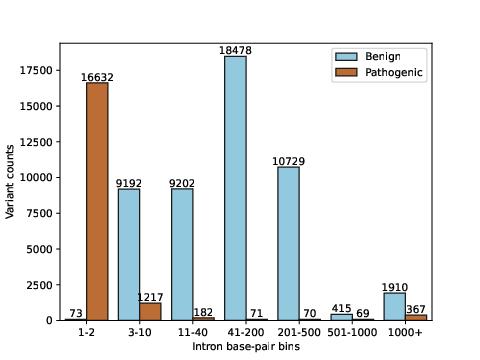

In [3]:
counts="/Users/pbarbosa/git_repos/paper_intronic_benchmark/out/out_clinvar_splicing/1s_l/intron_analysis/variant_counts/counts_per_intronic_bin_all.pdf"
img = WImage(filename=counts, resolution=75)
img

Performance drops significantly right after splice site positions, specially in donor-associated variants

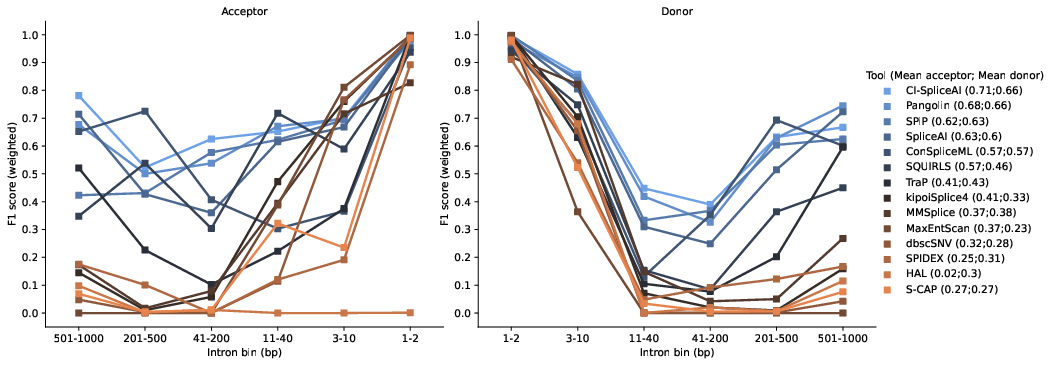

In [4]:
perf_per_bin="/Users/pbarbosa/git_repos/paper_intronic_benchmark/out/out_clinvar_splicing/1s_l/intron_analysis/all_bin_together/per_bin_all_split_ss_weighted_F1.pdf"
img = WImage(filename=perf_per_bin, resolution=75)
img

* ### Conservation scores

As for the Splicing tools, perfomance drops significantly after the two dinucleotides. However, there's a slight increase at deeper intronic space.

In [8]:
! rm data/clinvar/clinvar_to_VETA_evaluation.vcf.gz.tsv
! veta benchmark --out_dir out/out_clinvar_conservation \
    --scopes_to_evaluate Conservation \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --do_intronic_analysis \
    --split_splice_sites \
    data/clinvar/clinvar_to_VETA_evaluation.vcf.gz &> out/log_clinvar_conservation.txt 

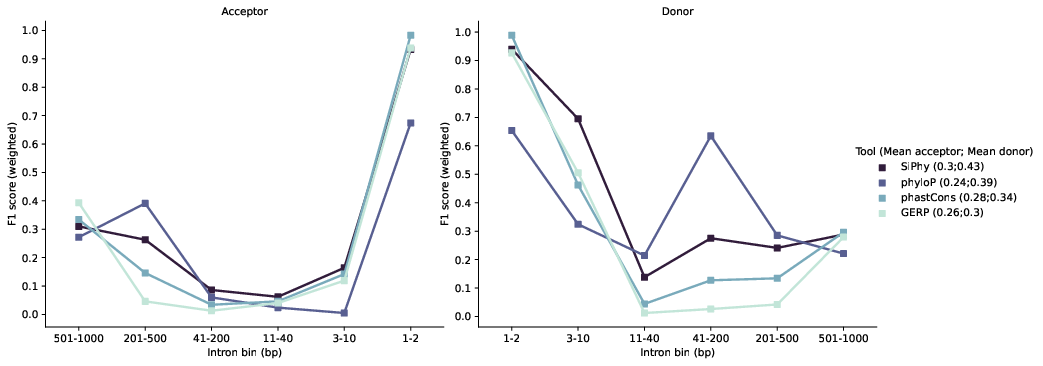

In [5]:
perf_per_bin="out/out_clinvar_conservation/1s_l/intron_analysis/all_bin_together/per_bin_all_split_ss_weighted_F1.pdf"
img = WImage(filename=perf_per_bin, resolution=75)
img

* ### Consequence agnostic predictors

In [9]:
! rm data/clinvar/clinvar_to_VETA_evaluation.vcf.gz.tsv
! veta benchmark --out_dir out/out_clinvar_whole_genome \
    --scopes_to_evaluate Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --do_intronic_analysis \
    --split_splice_sites \
    data/clinvar/clinvar_to_VETA_evaluation.vcf.gz &> out/log_clinvar_whole_genome.txt 

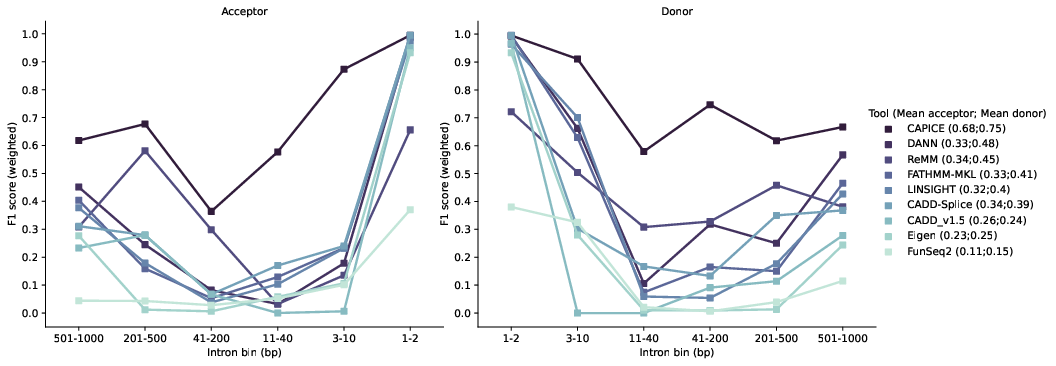

In [6]:
perf_per_bin="out/out_clinvar_whole_genome/1s_l/intron_analysis/all_bin_together/per_bin_all_split_ss_weighted_F1.pdf"
perf_per_bin="out/out_clinvar_whole_genome/1s_l/intron_analysis/all_bin_together/per_bin_all_split_ss_weighted_F1.pdf"
img = WImage(filename=perf_per_bin, resolution=75)
img

CAPICE stood out with a weighted F1 score mean of > 0.7 across bins. Since training variants of this model (as well as CADD and DANN) are available, we wanted to control for type I circularity issues. Hence, we excluded variants from our evaluation dataset that were used in the training of either CADD/DANN/CADD-Splice or CAPICE. This lead to a exclusion of 15,789 variants from the clinvar intronic dataset. Thus, we performed again the evaluation of consequence-agnostic predictors using 56,216 variants. Since we set the filtering strategy to `1s_l`, some 0 star pathogenic variants were also excluded (N=3359) during the VETA run. Total number of intronic variants evaluated equals to 52857.

In [14]:
! rm data/clinvar/circularity/clinvar_circularity_resilient.vcf.gz.tsv
! veta benchmark --out_dir out/out_clinvar_whole_genome_circularity \
    --scopes_to_evaluate Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --do_intronic_analysis \
    --split_splice_sites \
    data/clinvar/circularity/clinvar_circularity_resilient.vcf.gz &> out/log_clinvar_whole_genome_circularity.txt 

rm: data/clinvar/circularity/clinvar_circularity_resilient.vcf.gz.tsv: No such file or directory


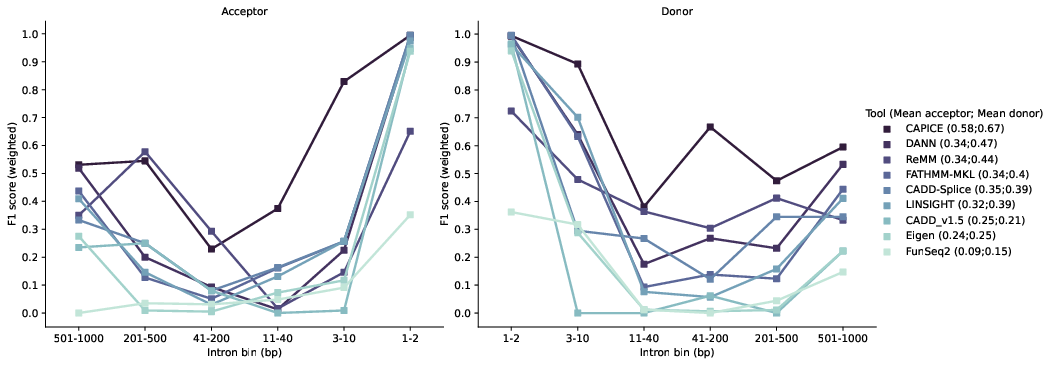

In [15]:
perf_per_bin="out/out_clinvar_whole_genome_circularity/1s_l/intron_analysis/all_bin_together/per_bin_all_split_ss_weighted_F1.pdf"
img = WImage(filename=perf_per_bin, resolution=75)
img

 * ### All tools together for specific analysis

In [23]:
! rm data/clinvar/circularity/clinvar_circularity_resilient.vcf.gz.tsv
! veta benchmark --out_dir out/out_clinvar_all \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --do_intronic_analysis \
    data/clinvar/circularity/clinvar_circularity_resilient.vcf.gz &> out/log_clinvar_all.txt

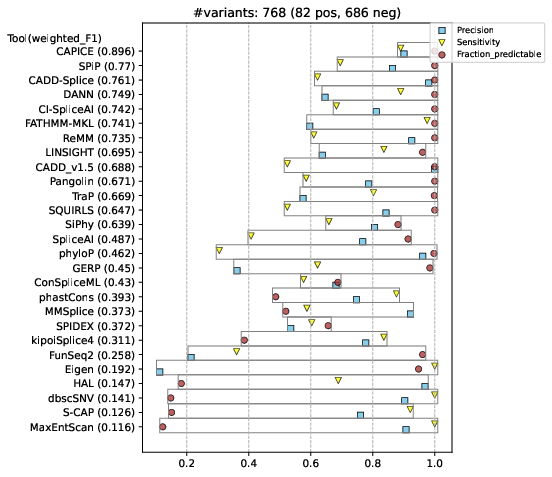

In [20]:
utr5="out/out_clinvar_all/1s_l/tools_benchmark/snps/performance_at_fixed_thresh/scatter_snps_5primeUTR.pdf"
img = WImage(filename=utr5, resolution=75)
img

## **Manually curated dataset of pathogenic intronic variation**

First, we will run a standard and faster benchmark without the `--do_intronic_analysis` flag. The goal is to see how all the tools behave overall, and test whether `Conservation` and `Whole_genome` (not splicing-specific) can be excluded from further analysis, since from now on all the variants evaluated are related with splicing aberrations.

Results show that most of these Conservation and Consequence-agnostic tools can be excluded (< 0.7), except for CADD-Splice. 

In [ ]:
from wand.image import Image as WImage

In [ ]:
! veta benchmark --out_dir out/out_manual_curation_all_tools \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/clinvar/tools_config.txt \
    data/manual_curation  &> out/log_manual_curation_all_tools.txt 

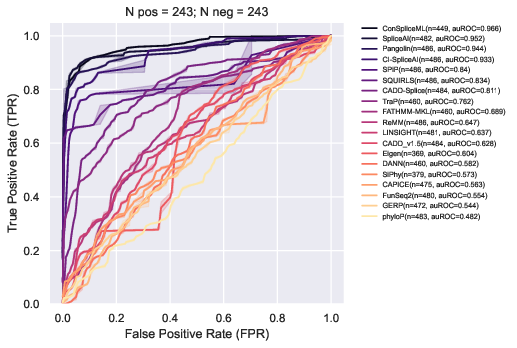

In [ ]:
overall_perf="out/out_manual_curation_all_tools/tools_benchmark/all_types/roc_analysis/ROC_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

Now, we run VETA for the selected tools and activate the `--do_threshold` and `--bootstrap` flag. We want to study how fit are the reference thresholds for deep intronic splicing-related variants. Clearly, some reference thresholds are not appropriate for distinguishing deep intronic pathogenic vs benign variants.

In [ ]:
! veta benchmark --out_dir out/out_manual_curation_thesholds \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/manual_curation/tools_config.txt \
    --do_threshold_analysis \
    --bootstrapping \
    data/manual_curation &> out/log_manual_curation_thresh.txt 

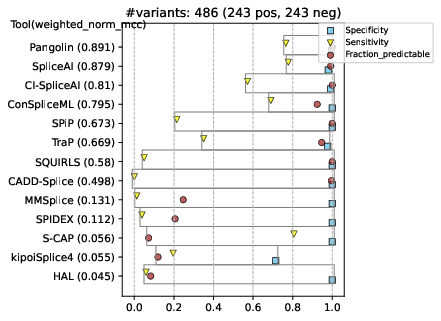

In [ ]:
overall_perf="out/out_manual_curation_thesholds/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

By running again a standard analysis using the new, adjusted thresholds, performance increases snicely.

In [ ]:
# ! cp out/out_manual_curation_thesholds/thresholds_analysis/new_configs/new_config_intronic_f1.txt data/manual_curation/
# ! veta benchmark --out_dir out/out_manual_curation_adjusted_thesh \
#     --types_of_variant all_types \
#     --metric weighted_norm_mcc \
#     --config data/manual_curation/new_config_intronic_f1.txt \
#     data/manual_curation  &> out/log_manual_curation_adjusted_thresh.txt 

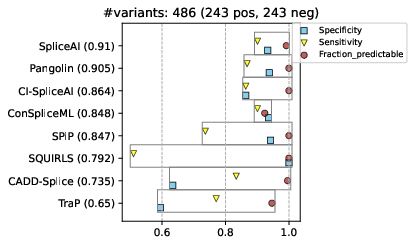

In [ ]:
overall_perf="out/out_manual_curation_adjusted_thesh/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

## **Variants affecting RNA splicing**

This section of the analysis focuses on the comparison of prediction tools to identify splicing-altering variants that do so by different mechanisms. Some alter the branchpoint signal in the intron upstream, others create a new splice site, others activate existing cryptic splice sites by a change in the surrounding nucleotide context. Here, we evaluate the performance of different methods on each class of variants separately. Additionally, we add several models that predict each class in particular. Several datasets were integrated and curated for this study:

* [VazDrago 2017](https://pubmed.ncbi.nlm.nih.gov/28497172/) and PedroBarbosa 2022 (N splicing altering=243): Our own curated list of disease-causing variants by means of alteration of RNA splicing. Used in the previous section, but here they are decomposed in different categories. 
* [Keegan 2022](https://pubmed.ncbi.nlm.nih.gov/35140743/) (N splicing altering=153): Comprehensive curation of variants that drive cryptic splicing, not all of them causing disease. Some overlap with our own curation, but many variants are unique. Large indels and coding variants were discarded. 
* [Petersen 2021](https://onlinelibrary.wiley.com/doi/full/10.1002/humu.24306) (N splicing altering=12): Comprehensive analysis of pseudoexon activation caused by intronic variants that do not create splice sites. Most of them create/repress/alter splicing regulatory elements within the generated pseudoexon. Many variants are already present in the two previous curation, hence the reduced final number of unique variants used.
* [Tubeuf 2020](https://onlinelibrary.wiley.com/doi/full/10.1002/humu.24091) (N splicing altering=3): Benchmark of user-friendly tools with variants that induce alterations in splicing regulatory elements. Most of variants collected are exonic, therefore we removed them. For a small set of intronic variants that induce pseudoexon activation (N=13), we selected 3 that are not present in any of the previous datasets collected.
* [Jung 2021](https://pubmed.ncbi.nlm.nih.gov/33420369/) (N splicing altering=252): Comprehensive caracterization of intronic mis-splicing in human cancers. They developed a method to caracterize intronic variation and its effect of splicing based on RNA-seq data. 
* [Moles-Fernández 2021](https://pubmed.ncbi.nlm.nih.gov/34283047/) (N splicing altering=19; N splicing neutral=99): Evaluation of the impact of splicing regulatory elements in the identification of variants in hereditary breast/ovarian cancer genes. Datasets collected from manual literature search as well as from other studies.
* [Adamson 2018](https://pubmed.ncbi.nlm.nih.gov/29859120/) (N splicing neutral=283): A MPRA to test the impact of 2059 variants in RNA-splicing spanning 110 alternative exons. Variants with no splicing effect (dPSI < 1) were selected, yielding a balanced number of exonic (to be compared with the splicing-altering variants ocurring within activated pseudoexons) and intronic variants.
* [Cheung 2019](https://pubmed.ncbi.nlm.nih.gov/30503770/) (N splicing neutral=109): Multiplexed functional assay (MFASS) that assayed the splicing effect of 27,733 variants from ExAC. Variants with no splicing effect (dPSI < 2 in both replicates) were selected. 

### **A) Splicing regulatory elements (SRE)**

This dataset is composed by 107 intronic variants that affect SREs and usually lead to the inclusion of pseudoexons (positive set). Variants from all sources were included here (VazDrago, PedroBarbosa, Petersen, Tubeuf, Moles_Fernandez, Keegan, Jung). The neutral dataset (variants that do not change splicing, negative set) refers to a set of exonic variants (to resemble as much as possible the positive set) that were proven to not affect splicing. This set comes exclusively from Adamson 20218 (N=123).

For this analysis, we additionally incorporate user-friendly tools such as HEXplorer, ESEfinder and also ESRscores originated from the QUEPASA method. The steps to generate VCFs with the variant effect scores of each method can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).
